This notebook evaluates a Vector Autoregressive Model with exogenous variables for conditional forecasting.

The data transformations and preparation are used from the Data-Transformations notebook.

## Import Packages

In [1]:
import gresearch_crypto

from datetime import datetime
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import gc
import numpy as np
import pandas as pd
import regex
from collections import Counter
import math

## Declare variables

In [2]:
train_filepath = '/kaggle/input/g-research-crypto-forecasting/train.csv'
asset_details_filepath = '/kaggle/input/g-research-crypto-forecasting/asset_details.csv'

## Declare Cleaning Functions

In [3]:
def clean_dates(df):
    '''
    Function to clean timestamps of an individual coin 
    by the earliest and latest timestamps observed for that coin.
    Also fills in missing values by the method chosen for the interpolate function.
    
    Inputs: 
        df (pd.DataFrame.GroupBy object) :
            Grouped Dataframe by unique coins. All timestamps must be
            in intervals of 60 seconds.

    Outputs:
        constant_dates_df (pd.DataFrame) :
            Dataframe with timestamps and filled missing values.
    '''
    
    df = df.copy()
    
    dates = range(min(df["timestamp"]), max(df["timestamp"]), 60)
    
    df.set_index("timestamp", inplace = True)
    
    df = df.reindex(dates)
    
    # replace the 9 infinite values with NaN, which are interpolated in the next line
    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    
    # don't fill missing values at end of dataset, where they do not
    # have ending observations to interpolate with
    df.interpolate(method = "linear", inplace = True, limit_area = "inside")
    
    return df
    
def standardize_data(df):
    '''
    Function to standardize data by creating rows for every timestamp
    and subsetting to only consider when all coins had their first observation made.
    
    Inputs:
        df (pd.DataFrame) :
            Time series data to be standardized
            
    Outputs:
        standard_df (pd.DataFrame) :
            Time series data now standardized
    '''
    
    # deep copy to not alter the original
    df = df.copy()
    
    # fill missing rows / values between coin's start and stop date
    # Note: Missing rows beyond an individual coin's start / stop date are not created,
    # only those between are filled in
    standard_df = df.groupby("Asset_ID").apply(clean_dates).reset_index(level = 0, drop = True)
    
    # reset twice so timestamp is only a column and not also index, 
    # this makes each entry have a unique index
    standard_df = standard_df.reset_index()
    
    # get the earliest timestamp for each coin, then get the latest timestamp out of those.
    # this shows when the latest coin was introduced, after which there are observations for
    # all coins
    first_timestamp = max(standard_df.groupby("Asset_ID")["timestamp"].min())
    
    # subset to only consider the time period where observations existed for all coins
    standard_df = standard_df.loc[standard_df["timestamp"] >= first_timestamp]
    
    # drop ending rows with missing values
    standard_df.dropna(inplace = True)
    
    # convert to int to better reflect nature of data
    standard_df["Count"] = standard_df["Count"].astype("int")
    standard_df["Asset_ID"] = standard_df["Asset_ID"].astype("int")
    
    return standard_df

def df_long_to_wide(df, group_column, cols_to_keep, time_col):
    '''
    Function to transform data from long to wide format.
    
    Assumes passed DataFrame is in long format, where each row corresponds to
    a unique observation in cross section and in time (i.e. the values of a specific
    coin at a specific time)
    
    Returns a formatted DataFrame in wide format, where each row corresponds only 
    to a unique time. 
    
    Inputs:
        df (pd.DataFrame) :
            Time series data in long format
            
        group_column (str) :
            String of the column to be grouped by, representing
            the cross sectional identifier of the data 
            (e.g. identifier for which coin out of 14 
            cryptocurrencies the row represents)
            
        cols_to_keep (list of strs) :
            List of strings, where each string represents a column
            to keep and include in the new wide dataframe. Each column
            will be repeated for each group (e.g. for two groups and
            three columns, each row will have six appended columns
            in the wide df) 
            
        time_col (str) :
            String of the column that contains time information
            
    Outputs:
        wide_df (pd.DataFrame) :
            Time series data in wide format
    '''
    
    df = df.copy()

    # extract only the unique times and sort them in a new dataframe
    unique_times = df.loc[:, time_col].unique()
    wide_df = pd.DataFrame(data = {time_col : sorted(unique_times)})

    grouped_df = df.groupby(group_column)
    group_list = [grouped_df.get_group(x).copy() for x in grouped_df.groups]

    for group in group_list:
        
        # create new unique names for the cols indicating which cross section
        # they belong to
        new_col_names = [name + "_" + str(group.loc[:, group_column].iloc[0]) 
                         for name in cols_to_keep]

        rename_dict = {col : new_col for col, new_col in zip(cols_to_keep, new_col_names)}
        group.rename(columns = rename_dict, inplace = True, errors = "raise")

        # add columns to the wide df
        wide_df = wide_df.merge(group.loc[:, new_col_names + [time_col]], on = time_col,
                               how = "left")

        gc.collect()

    return wide_df

def split_exogenous_variables(df, dep_cols, ex_cols):
    '''
    Function to split the exogenous (independent) variables 
    from the dependent variables. Takes a dataframe as returned by
    df_long_to_wide and returns new dataframes of only the 
    dependent and exogenous variables respectively.
    
    Inputs:
        df (pd.DataFrame) :
            Wide dataframe with both dependent and exogenous variables
            as returned by the function df_long_to_wide
            
        dep_cols (list) :
            List of column names for the dependent variables without
            any coin specific suffixes (e.g. Target rather than Target_0)
            
        ex_cols (list) :
            List of column names for the exogenous variables without
            any coin specific suffixes (e.g. Open rather than Open_0)
            
    Outputs:
        dep_df (pd.DataFrame) :
            Wide dataframe with only dependent variables
    
        ex_df (pd.DataFrame) :
            Wide dataframe with only exogenous variables
    '''
    
    # make deep copy to not alter original
    df = df.copy()
    
    dep_cols = [col + "_" + str(coin) 
               for col in dep_cols 
               for coin in asset_details_df.loc[:, "Asset_ID"]
              ]
    ex_cols = [col + "_" + str(coin) 
               for col in ex_cols 
               for coin in asset_details_df.loc[:, "Asset_ID"]
              ]
    
    dep_df = df.loc[:, dep_cols]
    ex_df = df.loc[:, ex_cols]
        
    return dep_df, ex_df

def weight_df(df, factor, weight_factor = None):
    '''
    Inputs:
    
        df (pd.DataFrame) :
            Dataframe whose columns will be weighted, i.e. multiplied by
            factor

        factor (int or float) :
            Factor to multiply all observations in the dependent variable by,
            used for increasing its magnitude from between 0 and 1 to a larger
            range

        weight_factor (None or pd.DataFrame) :
            If not none, dataframe containing the weights to multiply each
            dependent variable by separately. Weights are assumed to already
            be aligned with their respective dependent variables.
        
    Outputs:
    
        df (pd.DataFrame) :
            Dataframe with weighted columns
    '''
    
    df = df.copy()
    
    df = df * factor
    
    if weight_factor is not None:
        
        weight_factor.index = df.columns
        df = df * weight_factor
        
    return df

def unweight_df(df, factor, col_factor):
    '''
    Unweights each entry in df by factor, and each column additionally
    by col_factor.
    
    Inputs:
    
        df (pd.DataFrame) :
            Dataframe whose columns will be weighted, i.e. multiplied by
            factor

        factor (int or float) :
            Factor to multiply all observations in the dependent variable by,
            used for increasing its magnitude from between 0 and 1 to a larger
            range

        col_factor (None or pd.DataFrame) :
            If not none, dataframe containing the weights to multiply each
            dependent variable by separately. Weights are assumed to already
            be aligned with their respective dependent variables.
        
    Outputs:
    
        df (pd.DataFrame) :
            Dataframe with weighted columns
    '''
    
    df = df.copy()
    
    df = df / factor
    
    if col_factor is not None:
        
        col_factor.index = df.columns
        df = df / col_factor
        
    return df

## Import and Clean Data

In [4]:
df = pd.read_csv(train_filepath)
asset_details_df = pd.read_csv(asset_details_filepath)

dep_cols = ["Target"]
ex_cols = ["Open", "Close", "High", "Low", "Count", "Volume", "VWAP"]

# apply EDA transformations to make stationary
df.loc[:, ex_cols] = (np.log(df.loc[:, ex_cols])).diff()

standard_df = standardize_data(df)
standard_df = df_long_to_wide(standard_df, "Asset_ID", dep_cols + ex_cols, "timestamp")

latest_timestamp = standard_df.loc[:, "timestamp"].max()

# 60 seconds per minute, 60 minutes per hour, 24 hours per day, ~30 days per month,
# for 3 months
cutoff_timestamp = 60*60*24*30*3

standard_train_df = standard_df.loc[(latest_timestamp - standard_df["timestamp"]) > cutoff_timestamp]
standard_test_df = standard_df.loc[(latest_timestamp - standard_df["timestamp"]) <= cutoff_timestamp]

standard_train_df.set_index("timestamp", inplace = True)
standard_test_df.set_index("timestamp", inplace = True)

standard_train_dep_df, standard_train_ex_df = split_exogenous_variables(standard_train_df, 
                                                                        dep_cols, ex_cols)
standard_test_dep_df, standard_test_ex_df = split_exogenous_variables(standard_test_df, 
                                                                      dep_cols, ex_cols)

# apply weighting factors
#factor = 100000
#standard_train_dep_df = weight_df(standard_train_dep_df, factor, asset_details_df.loc[:, "Weight"])
#standard_test_df = weight_df(standard_test_dep_df, factor, None, dep_cols)


In [5]:
del df
gc.collect()

62

In [6]:
standard_train_dep_df

,Target_2,Target_0,Target_1,Target_5,Target_7,Target_6,Target_9,Target_11,Target_13,Target_12,Target_3,Target_8,Target_10,Target_4
timestamp,,,,,,,,,,,,,,
1555079640,-0.003690,-0.001787,-0.001882,-0.002293,-0.000829,-0.001438,0.002480,0.011912,-0.002559,-0.001524,-0.002951,0.027632,-0.019710,0.006126
1555079700,-0.001639,-0.001602,-0.000731,-0.001225,0.001051,-0.001777,0.003282,0.015584,-0.004204,-0.001226,-0.002924,0.000000,-0.019708,0.007576
1555079760,-0.002862,-0.000504,-0.001341,-0.002608,-0.007041,-0.001946,0.001506,0.014726,0.000026,-0.002385,-0.003826,0.026926,-0.019706,0.008655
1555079820,-0.000222,0.000566,-0.001508,-0.007047,-0.000373,-0.001211,0.000960,0.017296,-0.000975,-0.003115,-0.002333,0.002067,-0.019704,0.009373
1555079880,-0.005420,0.000000,-0.001657,-0.003066,-0.000014,-0.001697,0.000273,0.017488,-0.004186,-0.002968,-0.002824,0.027723,-0.019702,0.009369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624405140,0.001144,0.003837,-0.001987,-0.003792,0.000378,0.000044,-0.001514,-0.013900,-0.000036,0.001576,0.010975,0.009319,0.002873,-0.001471
1624405200,0.003616,0.005019,-0.002226,-0.002935,-0.000435,0.000567,0.001226,-0.012979,-0.000741,0.002292,0.010209,0.009596,0.005023,-0.002754
1624405260,0.001411,0.005909,-0.001798,-0.001701,-0.001410,0.001436,0.001162,-0.012925,0.000537,0.003187,0.007625,0.014052,0.005137,-0.001629


In [7]:
standard_train_ex_df

,Open_2,Open_0,Open_1,Open_5,Open_7,Open_6,Open_9,Open_11,Open_13,Open_12,...,VWAP_7,VWAP_6,VWAP_9,VWAP_11,VWAP_13,VWAP_12,VWAP_3,VWAP_8,VWAP_10,VWAP_4
timestamp,,,,,,,,,,,,,,,,,,,,,
1555079640,8.126158,-2.761681,5.647873,7.568987,0.169913,3.253645,5.531586,6.359334,-8.008438,1.470061,...,0.170115,3.253630,5.530852,6.358610,-8.007866,1.470234,-6.677364,-6.263146,2.086150,-14.416605
1555079700,8.127536,-2.763214,5.648140,7.571172,0.166623,3.255850,5.557843,6.358519,-8.006713,1.468385,...,0.166752,3.255464,5.558569,6.358885,-8.006992,1.468308,-6.676574,-6.290003,2.086202,-14.417736
1555079760,8.127290,-2.762714,5.647675,7.571814,0.167025,3.254872,5.531718,6.359241,-8.004749,1.465521,...,0.166677,3.254863,5.532090,6.358646,-8.005061,1.466223,-6.675303,-6.263435,2.086254,-14.417205
1555079820,8.125712,-2.762528,5.647190,7.573413,0.166263,3.253816,5.559720,6.359336,-8.009301,1.470793,...,0.165611,3.254316,5.558016,6.358668,-8.009448,1.470944,-6.675189,-6.288872,2.086307,-14.417600
1555079880,8.124744,-2.761991,5.647709,7.572459,0.165598,3.254760,5.531832,6.357628,-8.009255,1.471217,...,0.165578,3.254872,5.531736,6.357445,-8.009222,1.471273,-6.675789,-6.261451,2.086359,-14.417529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624405140,5.960016,-0.523648,4.825457,2.884649,2.371383,3.944903,5.150421,6.776404,-10.704148,1.520329,...,2.371391,3.944600,5.150527,6.775627,-10.705681,1.521324,-5.189557,-7.906288,2.947455,-12.057140
1624405200,5.961808,-0.524730,4.826476,2.884266,2.372855,3.943939,5.148400,6.775375,-10.705711,1.521617,...,2.373683,3.942809,5.148561,6.774128,-10.706296,1.522730,-5.189439,-7.903243,2.946913,-12.056505
1624405260,5.961169,-0.522684,4.824247,2.882942,2.372799,3.943557,5.149441,6.774027,-10.706297,1.521971,...,2.373838,3.942510,5.149203,6.774352,-10.705509,1.521674,-5.186473,-7.903876,2.946364,-12.054489


In [8]:
asset_details_df

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


## Declare evaluation functions

Special consideration must be given to the fact that predicted values are between 0 and 1. This makes certain operations and metrics, such as Root Mean Squared Error, inadvisable. 

In [9]:
def rmse(preds, true):
    '''
    Calculates Root Mean Squared Error (RMSE) between
    continuous predictions and true values.
    
    Inputs:
        preds (pd.DataFrame) :
            Predictions of the continous variable(s)
        
        true (pd.DataFrame) :
            True values of the continuous variable(s)
            
    Outputs:
        rmse (float) :
            RMSE as a float
    '''
    # align indices
    preds = preds.copy()
    true = true.copy()
    preds.index = true.index
    
    # get squared error for each coin
    se = (np.square(true.subtract(preds))).sum()

    # get mean squared error for each coin
    mse = se / len(true)

    # get root mean squared error for each coin
    rmse = (mse)**0.5
    
    return rmse
    
def binary_accuracy(preds, true):
    '''
    Calculates binary accuracy between
    continuous predictions and true values. Binary accuracy
    is 1 when the forecasted Target is of the same sign
    as the true Target, and zero otherwise.
    
    Inputs:
        preds (pd.DataFrame) :
            Predictions of the continous variable(s)
        
        true (pd.DataFrame) :
            True values of the continuous variable(s)
            
    Outputs:
        bin_pos_acc (pd.Series) :
            Binary accuracy for only positively valued
            predictions as a float
            
        bin_neg_acc (pd.Series) :
            Binary accuracy for only negatively valued
            predictions as a float
    
        bin_acc (pd.Series) :
            Binary accuracy as a float
    '''
    
    # align indices
    preds = preds.copy()
    true = true.copy()
    preds.index = true.index
    
    # find which predictions SHOULD have been
    # greater or less than zero
    true_pos = preds[true > 0]
    true_neg = preds[true < 0]
    
    num_pos_correct = true_pos[true_pos > 0].count()
    num_neg_correct = true_neg[true_neg < 0].count()
    num_correct = num_pos_correct + num_neg_correct
    
    num_total_pos = true_pos.count()
    num_total_neg = true_neg.count()
    num_total = true.count()
    
    bin_pos_acc = num_pos_correct / num_total_pos
    bin_neg_acc = num_neg_correct / num_total_neg
    bin_acc = num_correct / num_total
    
    return bin_pos_acc, bin_neg_acc, bin_acc

def corr(preds, true):
    '''
    Calculates Pearson correlation coefficient between 
    continuous predictions and true values.
    
    Inputs:
        preds (pd.DataFrame) :
            Predictions of the continous variable(s)
        
        true (pd.DataFrame) :
            True values of the continuous variable(s)
            
    Outputs:
        corr (pd.Series) :
            Pearson correlation coefficient for
            each group
    '''
    
    preds = preds.copy()
    true = true.copy()
    preds.index = true.index
    
    corr = preds.corrwith(true)
    
    return corr

def weighted_corr(preds, true, weights):
    '''
    Calculates weighted Pearson correlation coefficient 
    between continuous predictions and true values. Assumes
    each group to be weighted is separated by column in preds
    and true.
    
    Inputs:
        preds (pd.DataFrame) :
            Predictions of the continous variable(s)
        
        true (pd.DataFrame) :
            True values of the continuous variable(s)
            
        weights (pd.Series) :
            Weights 
            
    Outputs:
        weighted_corr (float) :
            Weighted Pearson correlation coefficient
            for entire set of observations
    '''
    
    preds = preds.copy()
    true = true.copy()
    weights = weights.copy()
    preds.index = true.index
    weights.index = preds.columns
    
    weighted_preds = preds * weights
    weighted_true = true * weights
    weight_sum = np.sum(weights * len(preds))

    weighted_preds_mean = np.sum(np.sum(weighted_preds)) / weight_sum
    weighted_true_mean = np.sum(np.sum(weighted_true)) / weight_sum

    weighted_preds_cov = np.sum(np.sum(weights * 
                          (preds - weighted_preds_mean) * 
                          (preds - weighted_preds_mean))) / weight_sum
    weighted_true_cov = np.sum(np.sum(weights * 
                          (true - weighted_true_mean) * 
                          (true - weighted_true_mean))) / weight_sum
    weighted_cov = np.sum(np.sum(weights * 
                          (preds - weighted_preds_mean) * 
                          (true - weighted_true_mean))) / weight_sum
    
    weighted_corr_ = weighted_cov / np.sqrt(weighted_preds_cov * weighted_true_cov)
    
    return weighted_corr_

## Define and Evaluate Models

In [10]:
gc.collect()
exog_variables = [
    ["Open", "Close", "High", "Low", "Count", "Volume", "VWAP"],
    ["Open", "Close", "High", "Low", "VWAP"],
    ["Open", "Close", "VWAP"],
    ["High", "Low", "VWAP"],
    ["VWAP"]
]
# select which model to keep for later visualization
save = [0, 0, 0, 0, 1]
best_fit_results = best_forecast_df = None

for exog_vars, i in zip(exog_variables, save): 

    print("\nCurrent exogenous variables include: " + str(exog_vars))
    print()
    
    coin_vars = [var + "_" + str(asset) 
             for var in exog_vars 
             for asset in asset_details_df.loc[:, "Asset_ID"]]
    
    # create model with current settings and make forecasts
    model = VAR(endog = standard_train_dep_df, 
                exog = standard_train_ex_df.loc[:, coin_vars])
    model_lag_order_results = model.select_order(15)
    selected_lags = model_lag_order_results.selected_orders["aic"]
    fit_results = model.fit(maxlags = selected_lags, trend = "n")
    forecasts = fit_results.forecast(y = standard_train_dep_df.iloc[-selected_lags:].values,
                                     steps = len(standard_test_dep_df),
                                     exog_future = standard_test_ex_df.loc[:, coin_vars])
    forecast_df = pd.DataFrame(data = forecasts, columns = standard_test_dep_df.columns)
    #forecast_df = unweight_df(forecast_df, factor, asset_details_df.loc[:, "Weight"])
    
    if i:
        best_fit_results = fit_results
        best_forecast_df = forecast_df
        
    print("Selected lag order based on AIC is " + str(selected_lags))
    
    # print evaluation metrics
    print("Percentage of non-significant coefficients: " +
        str(round(100*sum(sum(fit_results.pvalues.values > 0.05)) / fit_results.pvalues.values.size)) +
         "%\n")
    
    print("Input variables which are insignificant for majority of output variables: \n" + 
          str([
        col.split("_")[0] 

        for col, ct in 
        # dict containing input variable name : count of output variables the input is insignificant for
        Counter(
            [col.split("_")[0] for col in
             fit_results.pvalues[(
                 (# get count of how many times an individual variable (e.g. Count_1) was insignificant
                     fit_results.pvalues[fit_results.pvalues > 0.05].count(axis = 1) 
                     # get portion of the time an individual variable was insignificant
                     / len(fit_results.pvalues.columns)
                # subset to only variables which were insignificant for a majority of all outcomes
                ) > 0.5)]
        # get names of the variables (e.g. Count_1, L1.Target_1, etc.)
        .index]).items()

        # check if count of time variable is insignificant
        # is at least half of all outcome variables
        if (ct >= math.ceil(len(fit_results.pvalues.columns) / 2))
    ]))
    print()
    
    results_df = rmse(forecast_df, standard_test_dep_df).to_frame(name = "rmse")
    bin_pos_acc, bin_neg_acc, bin_acc = binary_accuracy(forecast_df, standard_test_dep_df)
    results_df["bin_acc_pos"] = 100*bin_pos_acc
    results_df["bin_acc_neg"] = 100*bin_neg_acc
    results_df["bin_acc_total"] = 100*bin_acc
    corr_ = corr(forecast_df, standard_test_dep_df)
    results_df["corr"] = corr_
    print(results_df)
    
    print("\nTotal RMSE: " + str(results_df["rmse"].sum()))
    print("Binary accuracy (%):")
    print("\tPositive")
    print("\tAverage: " + str(round((100*bin_pos_acc).mean(), 2)) + 
          ", Weighted Average: " + 
          str(round(np.average(100*bin_pos_acc.values, 
                         weights = asset_details_df.loc[:, "Weight"].values), 2)))
    print("\tNegative")
    print("\tAverage: " + str(round((100*bin_neg_acc).mean(), 2)) + 
          ", Weighted Average: " + 
          str(round(np.average(100*bin_neg_acc.values, 
                         weights = asset_details_df.loc[:, "Weight"].values), 2)))
    print("\tTotal")
    print("\tAverage: " + str(round((100*bin_acc).mean(), 2)) + 
          ", Weighted Average: " + 
          str(round(np.average(100*bin_acc.values, 
                         weights = asset_details_df.loc[:, "Weight"].values), 2)))
    print("Average unweighted correlation: " + str(round(np.average(corr_.values), 4)))
    print("Simple weighted correlation: " + 
          str(round(np.average(corr_.values, 
                               weights = asset_details_df.loc[:, "Weight"].values), 4)))
    weighted_corr_ = weighted_corr(forecast_df, standard_test_dep_df, asset_details_df.loc[:, "Weight"])
    print("Complex weighted correlation: " + str(round(weighted_corr_, 4)))

    
    del coin_vars
    del model
    del model_lag_order_results
    del selected_lags
    del fit_results
    del forecasts
    del forecast_df
    del results_df
    del bin_pos_acc
    del bin_neg_acc
    del bin_acc
    del corr_
    del weighted_corr_
    gc.collect()


Current exogenous variables include: ['Open', 'Close', 'High', 'Low', 'Count', 'Volume', 'VWAP']



/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Selected lag order based on AIC is 15
Percentage of non-significant coefficients: 40%

Input variables which are insignificant for majority of output variables: 
['Count', 'Volume', 'L7.Target', 'L8.Target']

               rmse  bin_acc_pos  bin_acc_neg  bin_acc_total      corr
Target_2   0.002152    40.998582    61.008692      51.425529  0.046782
Target_0   0.002576    58.395834    41.393743      49.805943 -0.013410
Target_1   0.001539    41.370249    58.968839      50.390815  0.020238
Target_5   0.002959    44.566515    58.552096      51.863026  0.026122
Target_7   0.003334    33.380335    67.089346      51.225685  0.021893
Target_6   0.001790    45.339361    56.847667      51.170901 -0.001350
Target_9   0.003143    43.514819    58.011058      51.040501 -0.059531
Target_11  0.004001    25.892607    72.423774      49.326780 -0.023201
Target_13  0.002938    62.763787    38.035815      50.286649 -0.002449
Target_12  0.003039    23.882435    77.874842      52.162406  0.022102
Target_3  

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Selected lag order based on AIC is 15
Percentage of non-significant coefficients: 37%

Input variables which are insignificant for majority of output variables: 
['L7.Target', 'L8.Target']

               rmse  bin_acc_pos  bin_acc_neg  bin_acc_total      corr
Target_2   0.002153    62.508861    39.060904      50.290507  0.044310
Target_0   0.002576    66.628725    33.910241      50.099922 -0.007836
Target_1   0.001540    26.136993    74.139696      50.741892  0.018556
Target_5   0.002960    46.029749    56.678252      51.585250  0.021722
Target_7   0.003331    40.138709    60.409561      50.869978  0.020852
Target_6   0.001790    42.267203    59.970764      51.238031 -0.005614
Target_9   0.003143    34.089122    67.365714      51.364573 -0.059389
Target_11  0.004003    25.442802    73.224705      49.507334 -0.021548
Target_13  0.002935    68.719338    32.570231      50.479549  0.010105
Target_12  0.003039    29.925955    71.745087      51.829847  0.017799
Target_3   0.003060    42.973

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Selected lag order based on AIC is 15
Percentage of non-significant coefficients: 38%

Input variables which are insignificant for majority of output variables: 
['L7.Target', 'L8.Target', 'L9.Target', 'L10.Target']

               rmse  bin_acc_pos  bin_acc_neg  bin_acc_total      corr
Target_2   0.002151    60.502997    41.553019      50.628467  0.052404
Target_0   0.002570    39.667566    60.127704      50.001157 -0.003143
Target_1   0.001540    15.429548    84.208942      50.684022  0.013602
Target_5   0.002948    51.264802    53.533979      52.448669  0.068009
Target_7   0.003332    93.220311     8.344265      48.287436  0.032473
Target_6   0.001789    44.616684    57.666890      51.229543 -0.012036
Target_9   0.003120    49.174409    53.815285      51.583707 -0.023350
Target_11  0.003977    54.817121    45.622444      50.162422  0.007679
Target_13  0.002932    22.213397    79.319784      51.026612 -0.010913
Target_12  0.003034    29.109350    73.135736      52.169351  0.037497
Ta

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Selected lag order based on AIC is 15
Percentage of non-significant coefficients: 38%

Input variables which are insignificant for majority of output variables: 
['L7.Target']

               rmse  bin_acc_pos  bin_acc_neg  bin_acc_total      corr
Target_2   0.002156    86.455178    13.772526      48.581415 -0.007109
Target_0   0.002573    66.499306    33.891910      50.026620 -0.011496
Target_1   0.001538     9.149768    91.226855      51.220284  0.016864
Target_5   0.002969    46.654083    52.312357      49.606099 -0.030047
Target_7   0.003333    42.363627    56.370791      49.778937 -0.000860
Target_6   0.001786    39.116833    61.994457      50.709485  0.004624
Target_9   0.003134    28.304369    70.320442      50.116897 -0.052958
Target_11  0.003998    23.769650    74.731619      49.437119 -0.023579
Target_13  0.002929    73.173543    27.139820      49.946374  0.020559
Target_12  0.003041    11.947698    87.367785      51.450992 -0.020470
Target_3   0.003059    42.619799    59.342

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Selected lag order based on AIC is 15
Percentage of non-significant coefficients: 41%

Input variables which are insignificant for majority of output variables: 
['VWAP', 'L7.Target', 'L8.Target', 'L10.Target']

               rmse  bin_acc_pos  bin_acc_neg  bin_acc_total      corr
Target_2   0.002154    91.636592     7.731035      47.914754  0.017434
Target_0   0.002570     1.312897    98.872663      50.592202 -0.008271
Target_1   0.001539     0.047490    99.933765      51.246518  0.008276
Target_5   0.002955    62.260833    37.133772      49.151627 -0.001164
Target_7   0.003333    99.985244     0.051013      47.080655  0.001087
Target_6   0.001784    14.151637    84.847424      49.974923  0.000098
Target_9   0.003107     7.562702    92.214857      51.509633 -0.004488
Target_11  0.003974    88.877821    10.948100      49.577550  0.011713
Target_13  0.002924     0.038935    99.966356      50.457944  0.006285
Target_12  0.003036     0.077772    99.945494      52.386170 -0.002478
Target_

In [11]:
gc.collect()

23

## Visualize Final Model

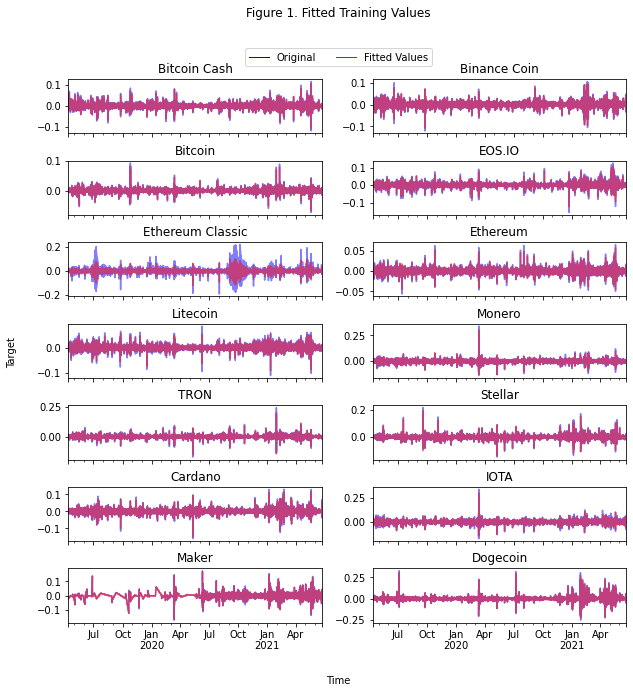

In [12]:
temp_df = standard_train_dep_df.copy().reset_index()
temp_df.loc[:, "datetime"] = pd.to_datetime(temp_df.loc[:, "timestamp"].values, 
                                                unit = "s", infer_datetime_format = True)
temp_fit = best_fit_results.fittedvalues.copy()
temp_fit["timestamp"] = temp_fit.index
temp_fit.loc[:, "datetime"] = pd.to_datetime(temp_fit.loc[:, "timestamp"].values, 
                                                unit = "s", infer_datetime_format = True)

fig, axes = plt.subplots(nrows = int(len(asset_details_df)/2), ncols = 2, 
                         sharex = True, figsize = (10,10))
axes = axes.flatten()

color_one = "blue"
color_two = "red"
alpha = 0.5

for ax, asset in zip(axes, asset_details_df["Asset_ID"]):
    col_string = "Target_" + str(asset)
    temp_df.plot(x = "datetime",
        y = col_string, ax = ax, legend = False, xlabel = "", ylabel = "", 
        color = color_one, alpha = alpha,
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    temp_fit.plot(x = "datetime",
        y = col_string, ax = ax, legend = False, xlabel = "", ylabel = "", 
        color = color_two, alpha = alpha,
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    
fig.suptitle("Figure 1. Fitted Training Values")
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Target', va='center', rotation='vertical')
fig.subplots_adjust(hspace=.5)

# create custom legend
handles = [Line2D([0], [0], color = color_one, lw = 1, label = 'Original'),
           Line2D([0], [0], color = color_two, lw = 1, label = 'Fitted Values')]

fig.legend(handles = handles, loc = "center", bbox_to_anchor=(0.5, 0.91), ncol = 2)

plt.savefig("train.png")    
plt.show()

In [13]:
del temp_df
del temp_fit
del fig
del axes
gc.collect()

91

In [14]:
plt.close()
gc.collect()

23

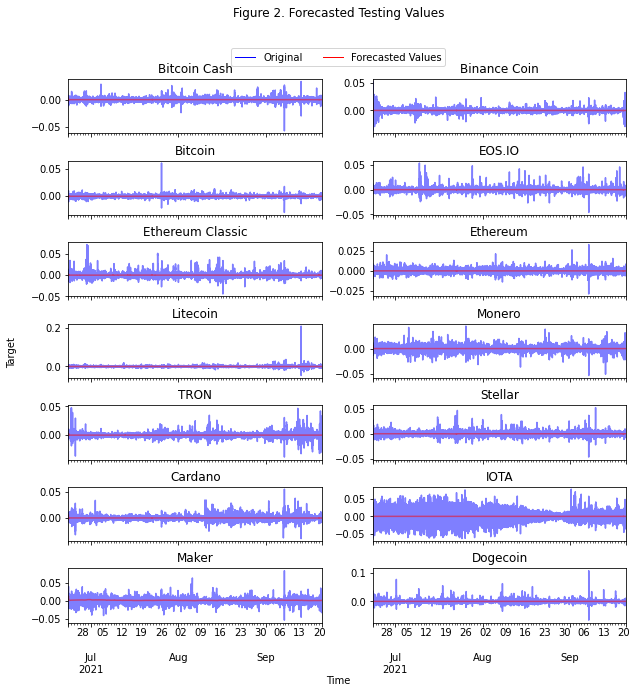

In [15]:
temp_df = standard_test_dep_df.copy().reset_index()
temp_df.loc[:, "datetime"] = pd.to_datetime(temp_df.loc[:, "timestamp"].values, 
                                                unit = "s", infer_datetime_format = True)

temp_fit = best_forecast_df.copy()
temp_fit.loc[:, "datetime"] = temp_df.loc[:, "datetime"].values.copy()

fig, axes = plt.subplots(nrows = int(len(asset_details_df)/2), ncols = 2, 
                         sharex = True, figsize = (10,10))
axes = axes.flatten()

color_one = "blue"
color_two = "red"
alpha = 0.5

for ax, asset in zip(axes, asset_details_df["Asset_ID"]):
    col_string = "Target_" + str(asset)
    temp_df.plot(x = "datetime",
        y = col_string, ax = ax, legend = False, xlabel = "", ylabel = "", 
        color = color_one, alpha = alpha,
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    temp_fit.plot(x = "datetime",
        y = col_string, ax = ax, legend = False, xlabel = "", ylabel = "", 
        color = color_two, alpha = alpha,
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    
fig.suptitle("Figure 2. Forecasted Testing Values")
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Target', va='center', rotation='vertical')
fig.subplots_adjust(hspace=.5)

# create custom legend
handles = [Line2D([0], [0], color = color_one, lw = 1, label = 'Original'),
           Line2D([0], [0], color = color_two, lw = 1, label = 'Forecasted Values')]

fig.legend(handles = handles, loc = "center", bbox_to_anchor=(0.5, 0.91), ncol = 2)

plt.savefig("test.png")    
plt.show()

In [16]:
del temp_df
del temp_fit
gc.collect()

58734